In [1]:
%load_ext autoreload
%autoreload 2

import os
import pymupdf
import numpy as np

from text import  TextWord, extract_words
from detect_language import detect_language_of_document
from bounding_box import cluster_drawings


In [2]:
base_dir = os.getcwd()
filename ="Berichte_NAB 10-025_Kurzarbeitsprogram Geothermiebohrung Schlattingen.PDF"
#filename = "ntb88-007.pdf"
#filename = "43283.pdf"

pdf_path = os.path.join(base_dir, "data/NAB", filename)
out_dir = os.path.join(base_dir, "data/test", os.path.splitext(filename)[0])


In [3]:
def is_digitally_born(page: pymupdf.Page) -> bool:
    bboxes = page.get_bboxlog()

    for boxType, rectangle in bboxes:
        # Empty rectangle that should be ignored occurs sometimes, e.g. SwissGeol 44191 page 37.
        if (boxType == "fill-text" or boxType == "stroke-text") and not pymupdf.Rect(rectangle).is_empty:
            return True
    return False

In [4]:
def classify_text_density(words, page_size):
    """
    Classifies a page as text-heavy or image-heavy based on word distribution.
    - words: List of TextWord objects
    - page_size: Tuple (width, height) of the page
    Returns:
        "text" if the page is likely a text page, otherwise "image".
    """
    if not words:
        return "No text"

    text_density = len(words) / (page_size[0] * page_size[1])  # Simple density 
    avg_word_height = sum(word.rect.height for word in words) / len(words)

    density_threshold = 0.0001  # Lower means more likely to be an image-heavy page
    height_threshold = 20  # If words are very large, the page may contain figures

    if text_density > density_threshold and avg_word_height < height_threshold:
        return "much text"
    return "little text"

In [98]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import laplacian
#use entroy, clustering, spacing frequency? or matriyy that shows conectivity? -> laplacian, knn isolation score or simple distance matrix?

def classify_wordpos(words: list[TextWord]):
    """Classifies text structure on page based on distribution."""
    
    if not words:
        print( "Unknown")
        return

    # Extract Y-axis positions and widths
    y_positions = np.array([word.rect.y0 for word in words])
    x_positions = np.array([word.rect.x0 for word in words])
    widths = np.array([word.rect.x1 - word.rect.x0 for word in words])
    heights = np.array([word.rect.y1 - word.rect.y0 for word in words])

    plt.hist2d(x_positions, y_positions, bins=(20, 20), cmap='Blues')
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.gca().invert_yaxis()
    plt.title("Text Bounding Box Distribution")
    plt.colorbar(label="Frequency")
    plt.show()

    # Compute pairwise Euclidean distances
    dist_matrix = squareform(pdist(y_positions.reshape(-1, 1)))
    # Convert distance matrix into a similarity graph (thresholding)
    threshold = np.percentile(dist_matrix, 20)  # Adjust threshold for connectivity
    graph_matrix = (dist_matrix < threshold).astype(int)
    # Compute Laplacian matrix
    lap_matrix = laplacian(graph_matrix, normed=True)
   
     
    # Compute spacing bewtween word to next word
    y_spacing = np.diff(np.sort(y_positions))  # Vertical distances
    x_spacing = np.diff(np.sort(x_positions))  # Horizontal distancs
    
    mean_y_spacing = np.mean(y_spacing) if len(y_spacing) > 0 else 0
    median_x_spacing = np.median(x_spacing) if len(x_spacing) > 0 else 0
    width_std = np.std(widths)
    height_std = np.std(heights)
     
    print(f"mean_y_spacing: {mean_y_spacing }")
    print(f"median width :{np.median(widths) }")
    print(f"width_std: {width_std }")
    print(f"median_x_spacing :{median_x_spacing }")
    print(f"height_std:{height_std}")
    print()


Page: 1 little text


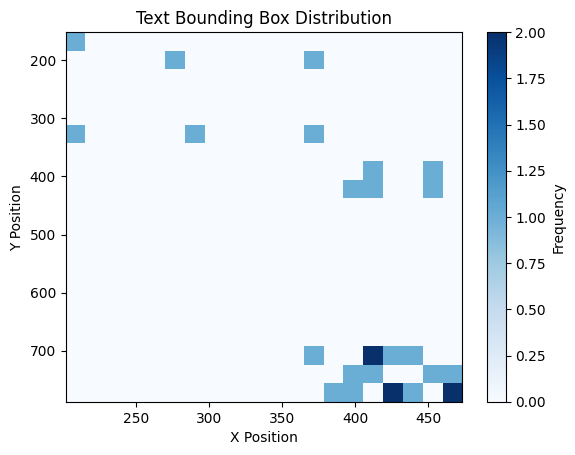

mean_y_spacing: 24.452549274151142
median width :40.39642333984375
width_std: 61.94029531954457
median_x_spacing :4.016693115234375
height_std:12.810119532907168

Page: 2 No text
Unknown


In [99]:
#classify page based on text
with pymupdf.open(pdf_path) as doc:
    for page_index,page in enumerate(doc):
        if page_index >1:
           break 
        page_number = page_index +1
        page_size = (page.rect.width, page.rect.height)
        
        words = extract_words(page, page_number)
        print(f"Page: {page_number}",classify_text_density(words,page_size))
        classify_wordpos(words)
        

In [7]:
def classify_digital(page):
    if page.get_images():
        return " image"

    drawings = page.get_drawings()
    if drawings:
        clustered_boxes = cluster_drawings(drawings)

        for cluster in clustered_boxes: #filter out small bboxes
            if cluster.get_area() > 100000:
                return " drawing"
    return " text"

In [8]:
##classify pdf based on image, drawing and text
with pymupdf.open(pdf_path) as doc:

    language = detect_language_of_document(doc)

    for page_index, page in enumerate(doc):
        page_number = page_index + 1
        page_size = (page.rect.width, page.rect.height)
        
        digitally_born = is_digitally_born(doc[page_index])

        if digitally_born:
            page_type = classify_digital(page)
        
        else:
            words = extract_words(page, page_number)
            page_type = classify_text_density(words, page_size)
        
        print(f"Page {page_number}: {page_type}")
        #print(f"Digitally born: {digitally_born}")
        #print()


Page 1:  drawing
Page 2: No text
Page 3:  text
Page 4:  text
Page 5:  text
Page 6:  text
Page 7:  text
Page 8:  image
Page 9:  text
Page 10:  image
Page 11:  image
Page 12:  image
Page 13:  text
Page 14:  drawing
Page 15:  text
Page 16:  text
Page 17:  text
Page 18:  text
Page 19:  text
Page 20:  text
Page 21:  text
Page 22:  image
Page 23:  drawing
Page 24:  text
Page 25:  text
Page 26:  text
Page 27:  image
Page 28: No text
Page 29:  image
Page 30: No text
Page 31:  text
Page 32:  image
Page 33:  text
Page 34:  text
